## Model Training for Neural Networks

In [9]:
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
# downlaod mnist dataset
# MNIST数据集是机器学习领域中非常经典的一个数据集，由60000个训练样本和10000个测试样本组成，每个样本都是一张28 * 28像素的灰度手写数字图片

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


mnist_train = torchvision.datasets.MNIST(
    root="../Data/MNIST", train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../Data/MNIST", train=False, transform=transform, download=True)

print(len(mnist_train), len(mnist_test))

60000 10000


In [11]:
# 加载测试集
train_loader = DataLoader(dataset=mnist_train,batch_size=64,shuffle=True,num_workers=0,drop_last=True)
test_loader = DataLoader(dataset=mnist_test,batch_size=64,shuffle=True,num_workers=0,drop_last=True)

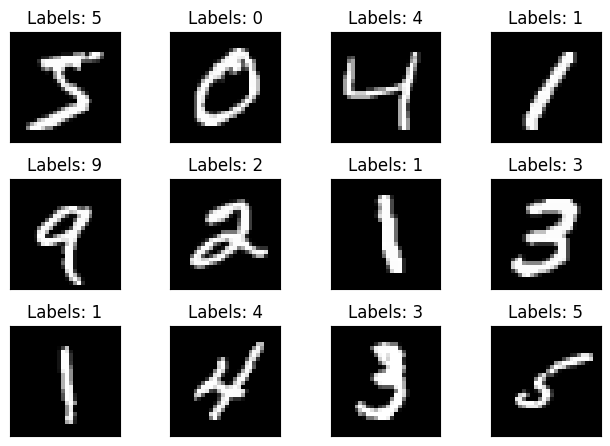

In [12]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(mnist_train.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(mnist_train.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [13]:
# 查看数据集
img, target = mnist_test[0]
print(img.shape)
print(target)

torch.Size([1, 28, 28])
7


In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(320, 50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [15]:
# super parameters
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# 实例化模型
model = Net()
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
criterion = criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

# 训练
# 前馈 --> 反馈 -- 更新

def train(epoch):
    
    running_loss = 0.0  # 累加当前 epoch 的损失
    running_total = 0   # 用于计数当前处理的样本总数
    running_correct = 0 # 用于计数当前 epoch 中预测正确的样本数
    
    for batch_idx, data in enumerate(train_loader, 0):
        # enumerate 是一个内置函数，它将可迭代对象（这里是 train_loader）转换为一个枚举对象，返回每个元素的索引和内容
        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step() # 更新模型参数

        
        running_loss += loss.item() # 把运行中的loss累加起来，为了下面300次一除
        
        _, predicted = torch.max(outputs.data, dim=1) # 把运行中的准确率acc算出来
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零


In [17]:
# test
def test(epoch):
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            
            total += labels.size(0)  # size(0) 是 PyTorch 中的一个方法，用于获取张量在第一个维度上的大小
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print(f'outputs_ize: {outputs.shape}')
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc


[1,   300]: loss: 0.860 , acc: 75.35 %
[1,   600]: loss: 0.250 , acc: 92.56 %
[1,   900]: loss: 0.163 , acc: 95.05 %
outputs_ize: torch.Size([64, 10])
[1 / 10]: Accuracy on test set: 96.2 % 
[2,   300]: loss: 0.119 , acc: 96.34 %
[2,   600]: loss: 0.114 , acc: 96.60 %
[2,   900]: loss: 0.095 , acc: 97.00 %
outputs_ize: torch.Size([64, 10])
[2 / 10]: Accuracy on test set: 97.5 % 
[3,   300]: loss: 0.083 , acc: 97.35 %
[3,   600]: loss: 0.079 , acc: 97.58 %
[3,   900]: loss: 0.075 , acc: 97.75 %
outputs_ize: torch.Size([64, 10])
[3 / 10]: Accuracy on test set: 97.9 % 
[4,   300]: loss: 0.069 , acc: 98.04 %
[4,   600]: loss: 0.066 , acc: 97.88 %
[4,   900]: loss: 0.061 , acc: 98.10 %
outputs_ize: torch.Size([64, 10])
[4 / 10]: Accuracy on test set: 98.1 % 
[5,   300]: loss: 0.057 , acc: 98.24 %
[5,   600]: loss: 0.057 , acc: 98.18 %
[5,   900]: loss: 0.059 , acc: 98.16 %
outputs_ize: torch.Size([64, 10])
[5 / 10]: Accuracy on test set: 98.4 % 
[6,   300]: loss: 0.051 , acc: 98.41 %
[6,   

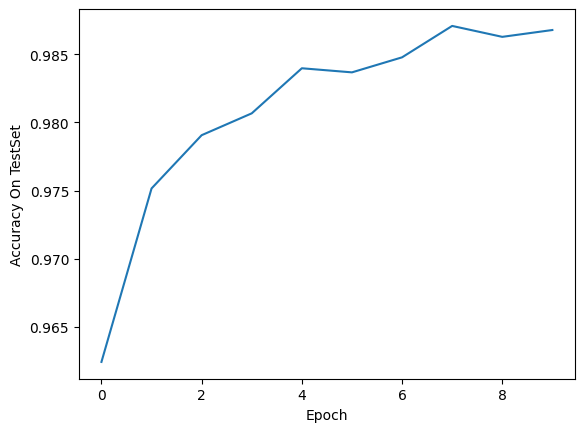

In [18]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        
        train(epoch)
        
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test(epoch)
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()
